In [1]:
# Import all necessary libraries and magics

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
%matplotlib inline
plt.style.use('bmh')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, Lasso, Ridge
import numpy as np

# Panda max columns view
pd.set_option('display.max_columns', 500)

In [2]:
dataset = pd.read_csv('datasets/dataset.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Disease     4920 non-null   object
 1   Symptom_1   4920 non-null   object
 2   Symptom_2   4920 non-null   object
 3   Symptom_3   4920 non-null   object
 4   Symptom_4   4572 non-null   object
 5   Symptom_5   3714 non-null   object
 6   Symptom_6   2934 non-null   object
 7   Symptom_7   2268 non-null   object
 8   Symptom_8   1944 non-null   object
 9   Symptom_9   1692 non-null   object
 10  Symptom_10  1512 non-null   object
 11  Symptom_11  1194 non-null   object
 12  Symptom_12  744 non-null    object
 13  Symptom_13  504 non-null    object
 14  Symptom_14  306 non-null    object
 15  Symptom_15  240 non-null    object
 16  Symptom_16  192 non-null    object
 17  Symptom_17  72 non-null     object
dtypes: object(18)
memory usage: 692.0+ KB


In [3]:
dataset.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Fungal infection,vomiting,vomiting,fatigue,high_fever,headache,nausea,abdominal_pain,abdominal_pain,yellowing_of_eyes,yellowing_of_eyes,irritability,malaise,muscle_pain,chest_pain,chest_pain,blood_in_sputum,muscle_pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


In [42]:
# Melt the DataFrame
df_melted = dataset.melt(id_vars=['Disease'], value_name='Symptom').drop(columns='variable')

# Remove rows where Symptom is an empty string
df_melted = df_melted[df_melted['Symptom'] != '']

# Add a constant column 'Count' with value 1
df_melted['Count'] = 1

# Create a binary DataFrame using pd.crosstab()
df_binary = pd.crosstab(index=df_melted['Disease'], columns=df_melted['Symptom'], values=df_melted['Count'], aggfunc='sum').fillna(0)

# Convert counts greater than 1 to 1
df_binary[df_binary.columns] = df_binary[df_binary.columns].clip(upper=1)

# Remove spaces from column names
df_binary.columns = df_binary.columns.str.replace(' ', '').str.strip()

# Merge with the original 'Disease' column to ensure all rows are retained
df_final = dataset[['Disease']].merge(df_binary, on='Disease', how='left').fillna(0)

t = df_final["Disease"]
X = df_final.drop('Disease', axis=1)


In [43]:
df_cols = pd.DataFrame(columns=X.columns)
df_cols.to_csv('cols.csv', index=False)

In [45]:
df_cols.columns.to_list()

['abdominal_pain',
 'abnormal_menstruation',
 'acidity',
 'acute_liver_failure',
 'altered_sensorium',
 'anxiety',
 'back_pain',
 'belly_pain',
 'blackheads',
 'bladder_discomfort',
 'blister',
 'blood_in_sputum',
 'bloody_stool',
 'blurred_and_distorted_vision',
 'breathlessness',
 'brittle_nails',
 'bruising',
 'burning_micturition',
 'chest_pain',
 'chills',
 'cold_hands_and_feets',
 'coma',
 'congestion',
 'constipation',
 'continuous_feel_of_urine',
 'continuous_sneezing',
 'cough',
 'cramps',
 'dark_urine',
 'dehydration',
 'depression',
 'diarrhoea',
 'dischromic_patches',
 'distention_of_abdomen',
 'dizziness',
 'drying_and_tingling_lips',
 'enlarged_thyroid',
 'excessive_hunger',
 'extra_marital_contacts',
 'family_history',
 'fast_heart_rate',
 'fatigue',
 'fluid_overload',
 'foul_smell_ofurine',
 'headache',
 'high_fever',
 'hip_joint_pain',
 'history_of_alcohol_consumption',
 'increased_appetite',
 'indigestion',
 'inflammatory_nails',
 'internal_itching',
 'irregular_sugar

In [58]:
# For the target variable
le = LabelEncoder()
t = le.fit_transform(t)
joblib.dump(le, 'le.pkl')

array([15, 15, 15, ..., 38, 35, 27])

In [47]:
# Split the dataset into training and test sets

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

In [48]:
X_train

,abdominal_pain,abnormal_menstruation,acidity,acute_liver_failure,altered_sensorium,anxiety,back_pain,belly_pain,blackheads,bladder_discomfort,blister,blood_in_sputum,bloody_stool,blurred_and_distorted_vision,breathlessness,brittle_nails,bruising,burning_micturition,chest_pain,chills,cold_hands_and_feets,coma,congestion,constipation,continuous_feel_of_urine,continuous_sneezing,cough,cramps,dark_urine,dehydration,depression,diarrhoea,dischromic_patches,distention_of_abdomen,dizziness,drying_and_tingling_lips,enlarged_thyroid,excessive_hunger,extra_marital_contacts,family_history,fast_heart_rate,fatigue,fluid_overload,foul_smell_ofurine,headache,high_fever,hip_joint_pain,history_of_alcohol_consumption,increased_appetite,indigestion,inflammatory_nails,internal_itching,irregular_sugar_level,irritability,irritation_in_anus,joint_pain,knee_pain,lack_of_concentration,lethargy,loss_of_appetite,loss_of_balance,loss_of_smell,malaise,mild_fever,mood_swings,movement_stiffness,mucoid_sputum,muscle_pain,muscle_wasting,muscle_weakness,nausea,neck_pain,nodal_skin_eruptions,obesity,pain_behind_the_eyes,pain_during_bowel_movements,pain_in_anal_region,painful_walking,palpitations,passage_of_gases,patches_in_throat,phlegm,polyuria,prominent_veins_on_calf,puffy_face_and_eyes,pus_filled_pimples,receiving_blood_transfusion,receiving_unsterile_injections,red_sore_around_nose,red_spots_over_body,redness_of_eyes,restlessness,runny_nose,rusty_sputum,scurring,shivering,silver_like_dusting,sinus_pressure,skin_peeling,skin_rash,slurred_speech,small_dents_in_nails,spinning_movements,spotting_urination,stiff_neck,stomach_bleeding,stomach_pain,sunken_eyes,sweating,swelled_lymph_nodes,swelling_joints,swelling_of_stomach,swollen_blood_vessels,swollen_extremeties,swollen_legs,throat_irritation,toxic_look_(typhos),ulcers_on_tongue,unsteadiness,visual_disturbances,vomiting,watering_from_eyes,weakness_in_limbs,weakness_of_one_body_side,weight_gain,weight_loss,yellow_crust_ooze,yellow_urine,yellowing_of_eyes,yellowish_skin,itching
1807,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
184,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
4581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [49]:
# Create a pipeline for the classifier

model = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000))
])

# Fit the model
model.fit(X_train, t_train)

# Save model using joblib
import joblib
joblib.dump(model, 'model.pkl')

['model.pkl']

In [8]:
def confidence_interval(X, t, model, scoring_func, confidence=0.95, cv=10, set="Training"):
    # Use scoring function for multiple functions
    scoring = scoring_func.__name__.split('_')[0]

    # Get cross validation scores
    y = model.predict(X)
    scores_val = cross_val_score(model, X, t,
                                scoring=scoring, cv=cv)
    
    # Print results
    print(f'{set} {scoring}: {scoring_func(t, y):.5f}')
    interval = stats.t.interval(confidence,
                                    len(scores_val)-1,
                                    loc = scores_val.mean(),
                                    scale=scores_val.std(ddof=1)/np.sqrt(len(scores_val)))
    print(f'Confidence Interval: [ {interval[0]:.5f} : {interval[1]:.5f} ]')
    print(f'Span: {interval[1]-interval[0]:.5f}')

Training Confusion Matrix
Test Confusion Matrix


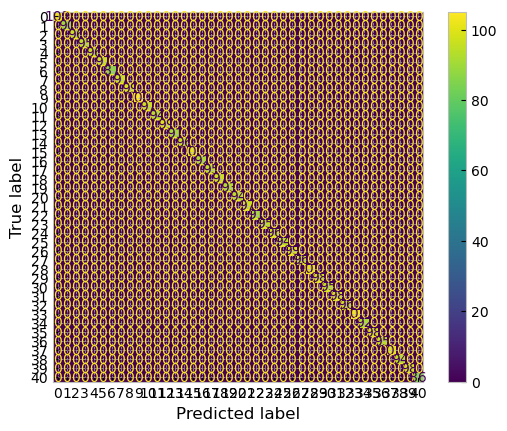

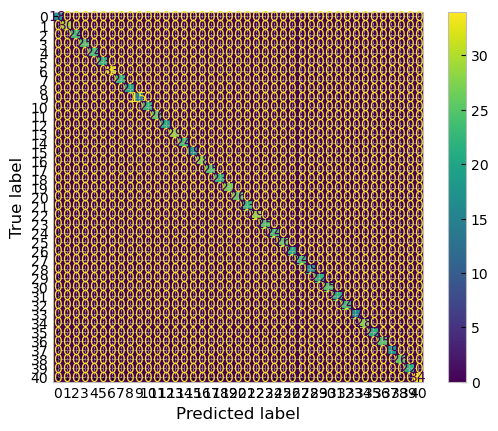

In [14]:
print("Training Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(t_train, model.predict(X_train))).plot();

print("Test Confusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(t_test, model.predict(X_test))).plot();